## This notebook learns the shifter model for a particular session.
Before running this script, you must export a stimulus file

In [1]:
import os, sys

sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('./scripts/'))

datadir = '/mnt/Data/Datasets/MitchellV1FreeViewing/stim_movies/' 

import numpy as np
import matplotlib.pyplot as plt
import torch

from datasets.pixel import Pixel
from datasets.pixel.utils import get_stim_list

train_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

%load_ext autoreload
%autoreload 2


## Load Data
The exported data is stored as an *.hdf5 file. The `Pixel` dataset has methods to access the stimulus and spikes times and format them so that they are ready for model fitting.

The data is saved in a format that has dimensions N x W x H. N grayscale frames of the stimulus were reconstructed within the Region Of Interest (ROI) of the neuron receptive fields. The ROI has a width W, and height H. The `Pixel` dataset embeds the previous `num_lags` frames of the stimulus as an extra dimension so the new dimensionality is [N x W x H x num_lags].

In [2]:
valid_eye_rad = 6 # range of gaze positions to consider w.r.t. the center of the screen
tdownsample = 2 # downsample the time resolution by this factor
num_lags = 24 # number of time lags to embed in the stimulus
SESSION_NAME = '20220610'


ds = Pixel(datadir,
    sess_list=[SESSION_NAME],
    requested_stims=['Gabor', 'BackImage'],
    num_lags=num_lags,
    downsample_t=tdownsample,
    valid_eye_rad=valid_eye_rad,
    spike_sorting='kilo',
    fixations_only=True, # only use fixations (cut out saccade times and some surrounding windows)
    )

'''
    Compute the data filters. Data filters are a mask that is applied to the data that dictates when individual neurons contribute to the log-likelihood.
    Because these data were recorded from electrode arrays, the firing rates of some neurons are not stable throughout the entire experiment. This harms 
    likelihood-based estimation of models.
'''
print('calculating datafilters')
ds.compute_datafilters(
    to_plot=False,
    verbose=False,
    frac_reject=0.25,
    Lhole=20)

print('[%.2f] fraction of the data used' %ds.covariates['dfs'].mean().item())

Found 175727 fixation indices
265313 valid indices
New valid size: 158121
Found 102626 fixation indices
175542 valid indices
New valid size: 93278
Loading data...
Removing discontinuitites
Removing discontinuitites
calculating datafilters


/home/jake/Data/anaconda3/envs/NDN/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jake/Data/anaconda3/envs/NDN/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/mnt/Data/Repos/yates-beyond-fixation/scripts/datasets/pixel/utils.py:254: RuntimeWarning: invalid value encountered in long_scalars
  stability_ratio = len(np.where(abs(mx[df > 0]-m) > np.sqrt(m))[0])/np.sum(df > 0)


[0.78] fraction of the data used


## Crop the ROI around the RFs
All fitting is MUCH faster if the entire dataset can fit on the GPU. Otherwise, the overhead from copying batches to the GPU slows things down substantially. The stimulus is the largest part of the data, but because the Receptive Fields are small, we can crop around the center of the RFs. To find the RF centers, we compute the Spike-Triggered Energy of the Gabor stimulus, average across all units and center a window around that.

100%|██████████| 82/82 [00:11<00:00,  7.19it/s]


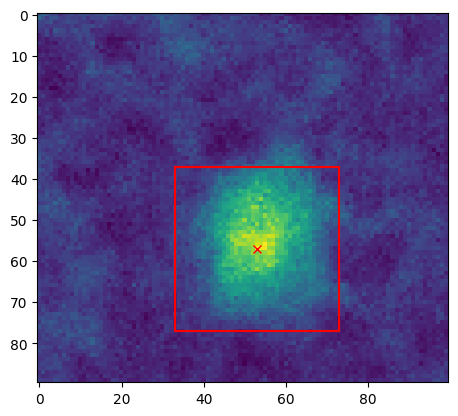

In [3]:
window_size = 40 # size of the crop window in pixels

# get indices into the gabor stimulus
gab_inds = np.where(np.in1d(ds.valid_idx, ds.stim_indices[ds.sess_list[0]]['Gabor']['inds']))[0].tolist()

FracDF_include = .2 # include all units that have more than less than 20% of their time points excluded with the data filter
cids = np.where(ds.covariates['dfs'].sum(dim=0) / ds.covariates['dfs'].shape[0] > FracDF_include)[0]

# run the crop window analysis
crop_window = ds.get_crop_window(inds=gab_inds, win_size=window_size, cids=cids, plot=True)
ds.crop_idx = crop_window # set the crop window. The Pixel dataset will handle this automatically

stas = ds.get_stas(inds=gab_inds, square=True) # recompute spike-triggered average energy for all units at crop resolution



## Split into training, validation, and test indices, and put the dataset on the GPU

In [4]:
from NDNT.utils import get_max_samples
if train_device.type == 'cpu':
    maxsamples = len(ds)
else:
    maxsamples = get_max_samples(ds, train_device)

train_inds, val_inds = ds.get_train_indices(max_sample=int(0.85*maxsamples))

train_data = ds[train_inds]
train_data['stim'] = torch.flatten(train_data['stim'], start_dim=1)
val_data = ds[val_inds]
val_data['stim'] = torch.flatten(val_data['stim'], start_dim=1)

cids = np.where(ds.covariates['dfs'].sum(dim=0) / ds.covariates['dfs'].shape[0] > FracDF_include)[0]
cids = np.intersect1d(cids, np.where(stas.sum(dim=(0,1,2))>0)[0])

input_dims = ds.dims + [ds.num_lags]

#%% Put dataset on GPU if requested
val_device = torch.device('cpu') # if you're cutting it close, put the validation set on the cpu
#%% Build datasets / dataloaders
from datasets.generic import GenericDataset

batch_size = 1000

train_ds = GenericDataset(train_data, device=dataset_device)
val_ds = GenericDataset(val_data, device=torch.device('cpu'))

from torch.utils.data import DataLoader

if dataset_device == torch.device('cpu'):
    print("Dataloaders are on the cpu")
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()//2, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=os.cpu_count()//2, pin_memory=True)
else:
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size)

Invoking __init__.py for NDNT.utils
# samples that can fit on device: 154.315 K


In [5]:
from models import CNNdense, Shifter
from copy import deepcopy
from NDNT.training import Trainer, EarlyStopping
from NDNT.utils import load_model


def fit_shifter_model(cp_dir, affine=False, overwrite=False):
    from hires import memory_clear

    # manually name the model
    name = 'CNN_shifter'
    if affine:
        name = name + '_affine'
    
    # load best model if it already exists
    exists = os.path.isdir(os.path.join(cp_dir, name))
    if exists and not overwrite:
        try:
            smod = load_model(cp_dir, name)

            smod.to(dataset_device)
            val_loss_min = 0
            for data in val_dl:
                out = smod.validation_step(data)
                val_loss_min += out['loss'].item()

            val_loss_min/=len(val_dl)    
            return smod, val_loss_min
        except:
            pass

    os.makedirs(cp_dir, exist_ok=True)

    # parameters of architecture
    num_filters = [20, 20, 20, 20]
    filter_width = [11, 9, 7, 7]
    num_inh = [0]*len(num_filters)
    scaffold = [len(num_filters)-1]

    # build CNN
    cr0 = CNNdense(input_dims,
            num_subunits=num_filters,
            filter_width=filter_width,
            num_inh=num_inh,
            cids=cids,
            bias=False,
            scaffold=scaffold,
            is_temporal=False,
            batch_norm=True,
            window='hamming',
            norm_type=0,
            reg_core=None,
            reg_hidden=None,
            reg_readout={'glocalx':1},
            reg_vals_feat={'l1':0.01, 'norm':1},
                        )
    
    # initialize parameters
    cr0.bias.data = torch.log(torch.exp(ds.covariates['robs'][:,cids].mean(dim=0)) - 1)
    
    # build regularization modules
    cr0.prepare_regularization()

    # wrap in a shifter network
    smod = Shifter(cr0, affine=affine)
    smod.name = name

    optimizer = torch.optim.Adam(smod.parameters(), lr=0.001)
    
    # minimal early stopping patience is all we need here
    earlystopping = EarlyStopping(patience=3, verbose=False)

    trainer = Trainer(optimizer=optimizer,
        device = train_device,
        dirpath = os.path.join(cp_dir, smod.name),
        log_activations=False,
        early_stopping=earlystopping,
        verbose=2,
        max_epochs=100)

    # fit and cleanup memory
    memory_clear()
    trainer.fit(smod, train_dl, val_dl)
    val_loss_min = deepcopy(trainer.val_loss_min)
    del trainer
    memory_clear()
    
    return smod, val_loss_min

/home/jake/Data/anaconda3/envs/NDN/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /mnt/Data/anaconda3/envs/NDN/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [8]:
from hires import seed_everything

seed = 1234

NBname = f'shifter_{SESSION_NAME}_{seed}'
cwd = os.getcwd()
dirname = os.path.join(cwd, 'data')
cp_dir = os.path.join(dirname, NBname)

# fit shifter with translation only
seed_everything(seed)
mod0, loss0 = fit_shifter_model(cp_dir, affine=False, overwrite=True)


GPU Available: True, GPU Used: True


Validating ver=1: 100%|██████████| 25/25 [00:02<00:00,  9.06it/s, val_loss=0.083] 


Early stopping
Done fitting


## Calculate the Null-adjusted log-likelihood per neuron

In [11]:
from models.utils import eval_model
ll0 = eval_model(mod0, val_dl)



Eval models: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


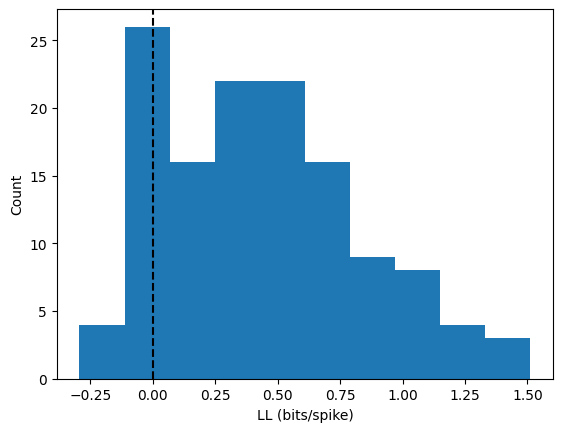

In [12]:
fig = plt.figure()
plt.hist(ll0)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("LL (bits/spike)")
plt.ylabel("Count")
plt.show()

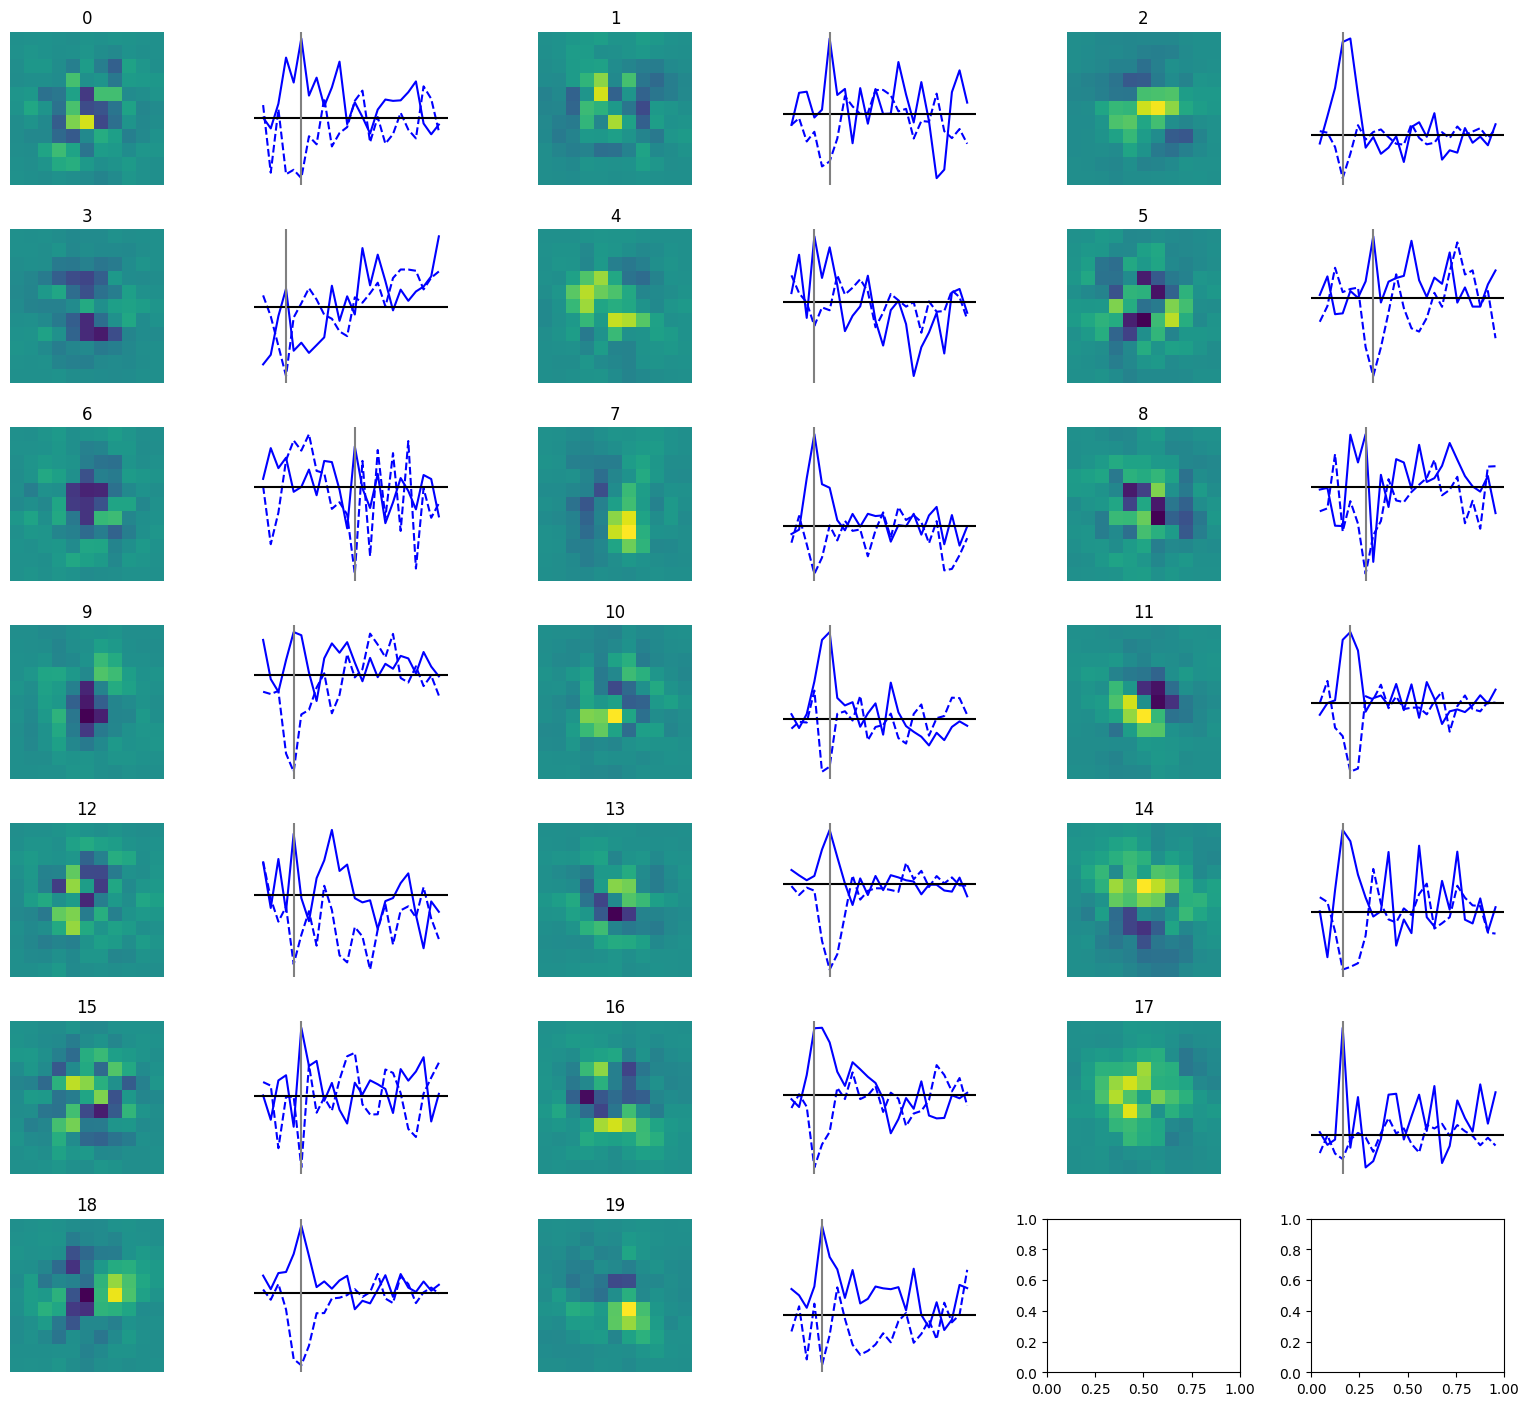

In [13]:
# Plot the learned weights from the first layer
mod0.model.core[0].plot_filters()

## Visualize the shifter output as a calibration matrix
The plot below shows the amount to shift as a function of the gaze position. This is similar to Figure 4b from the manuscript except for a different experimental session.

/tmp/ipykernel_143054/1774880750.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  y = (train_data['robs'][iix,:]*train_data['dfs'][iix,:])/train_data['dfs'][iix,:].sum(dim=0).T


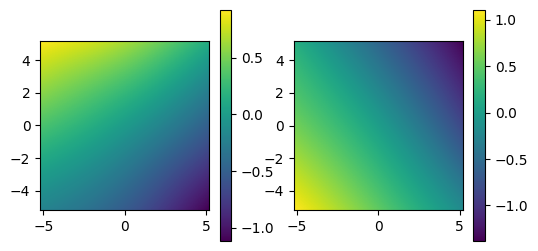

In [14]:
from datasets.pixel.utils import plot_shifter
from models.utils import plot_stas

_,fig00 = plot_shifter(mod0.shifter, show=False)

# %% plot STAs before and after shifting
iix = (train_data['stimid']==0).flatten()
y = (train_data['robs'][iix,:]*train_data['dfs'][iix,:])/train_data['dfs'][iix,:].sum(dim=0).T
stas = (train_data['stim'][iix,...].T@y).reshape(input_dims[1:] + [-1]).permute(2,0,1,3)

# do shift correction
shift = mod0.shifter(train_data['eyepos'])
stas0 = (mod0.shift_stim(train_data['stim'], shift)[iix,...].T@y).reshape(input_dims[1:] + [-1]).permute(2,0,1,3)

## Check the effect of shifting on the STA
Plot the spike-triggered average for each unit before and after shifting, Each subplot shows an image of the STA at the peak lag. The red and blue lines are the temporal values at the maximum and minimum value of the spatial RF.

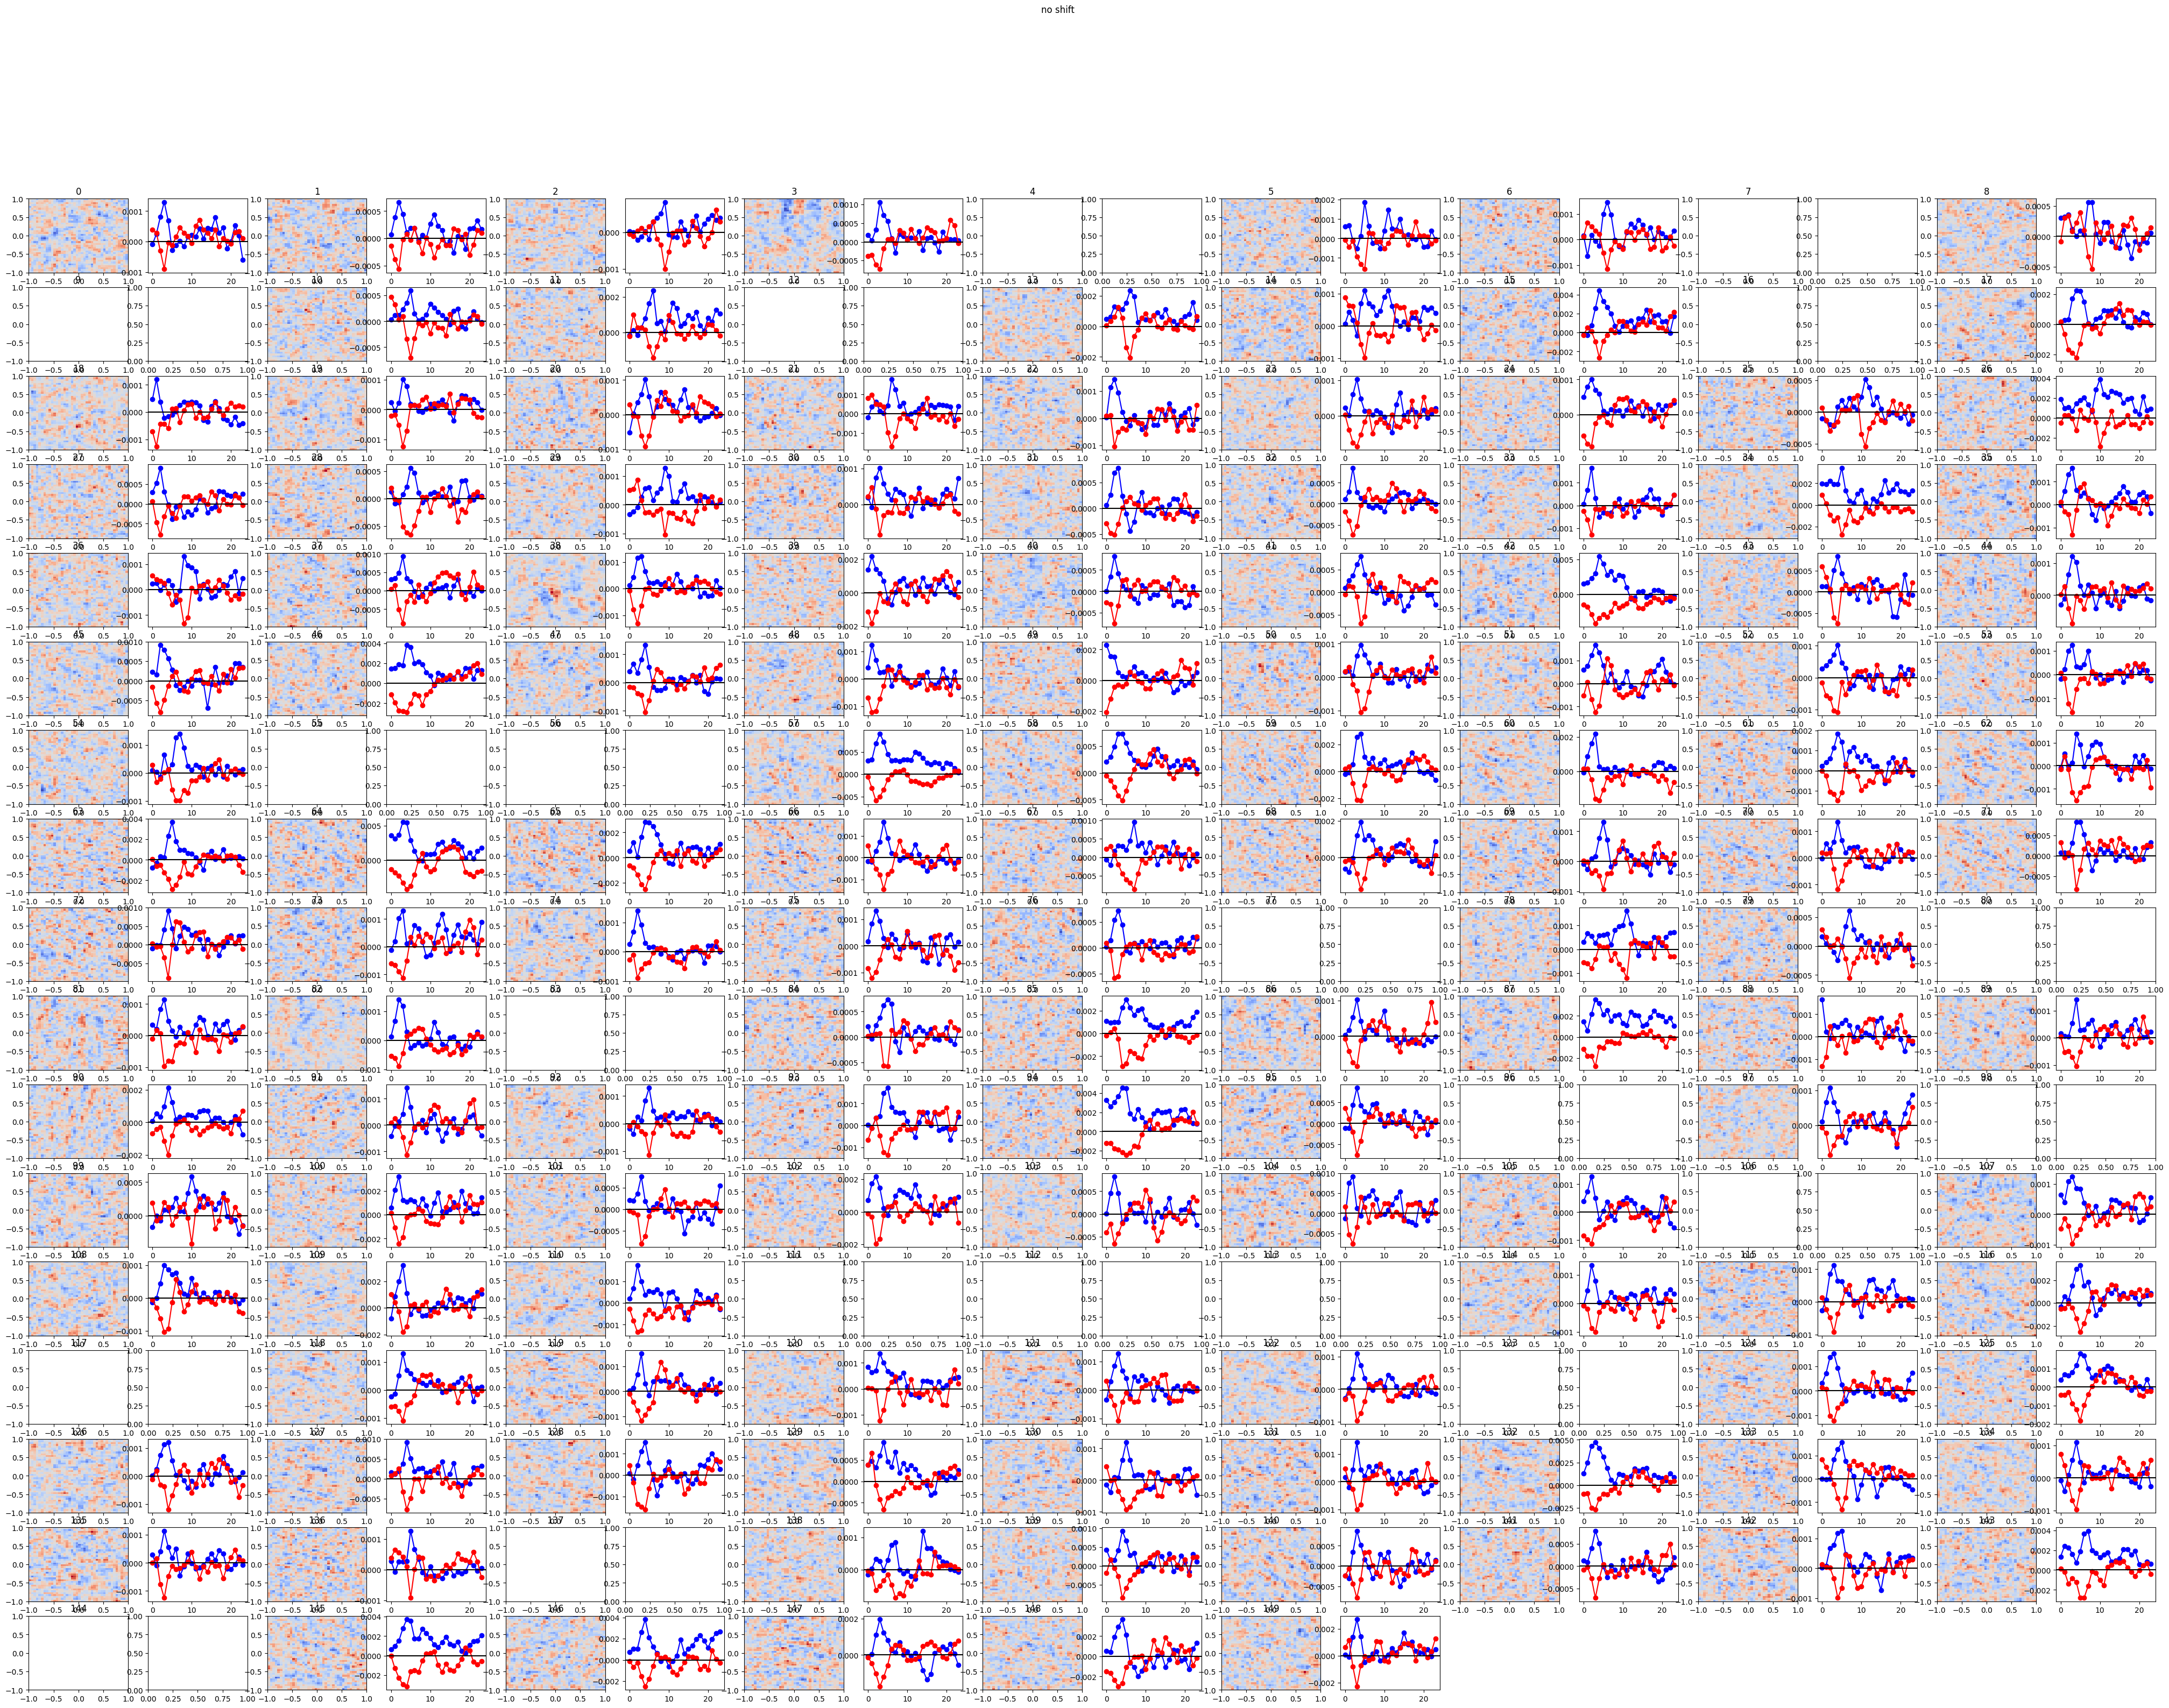

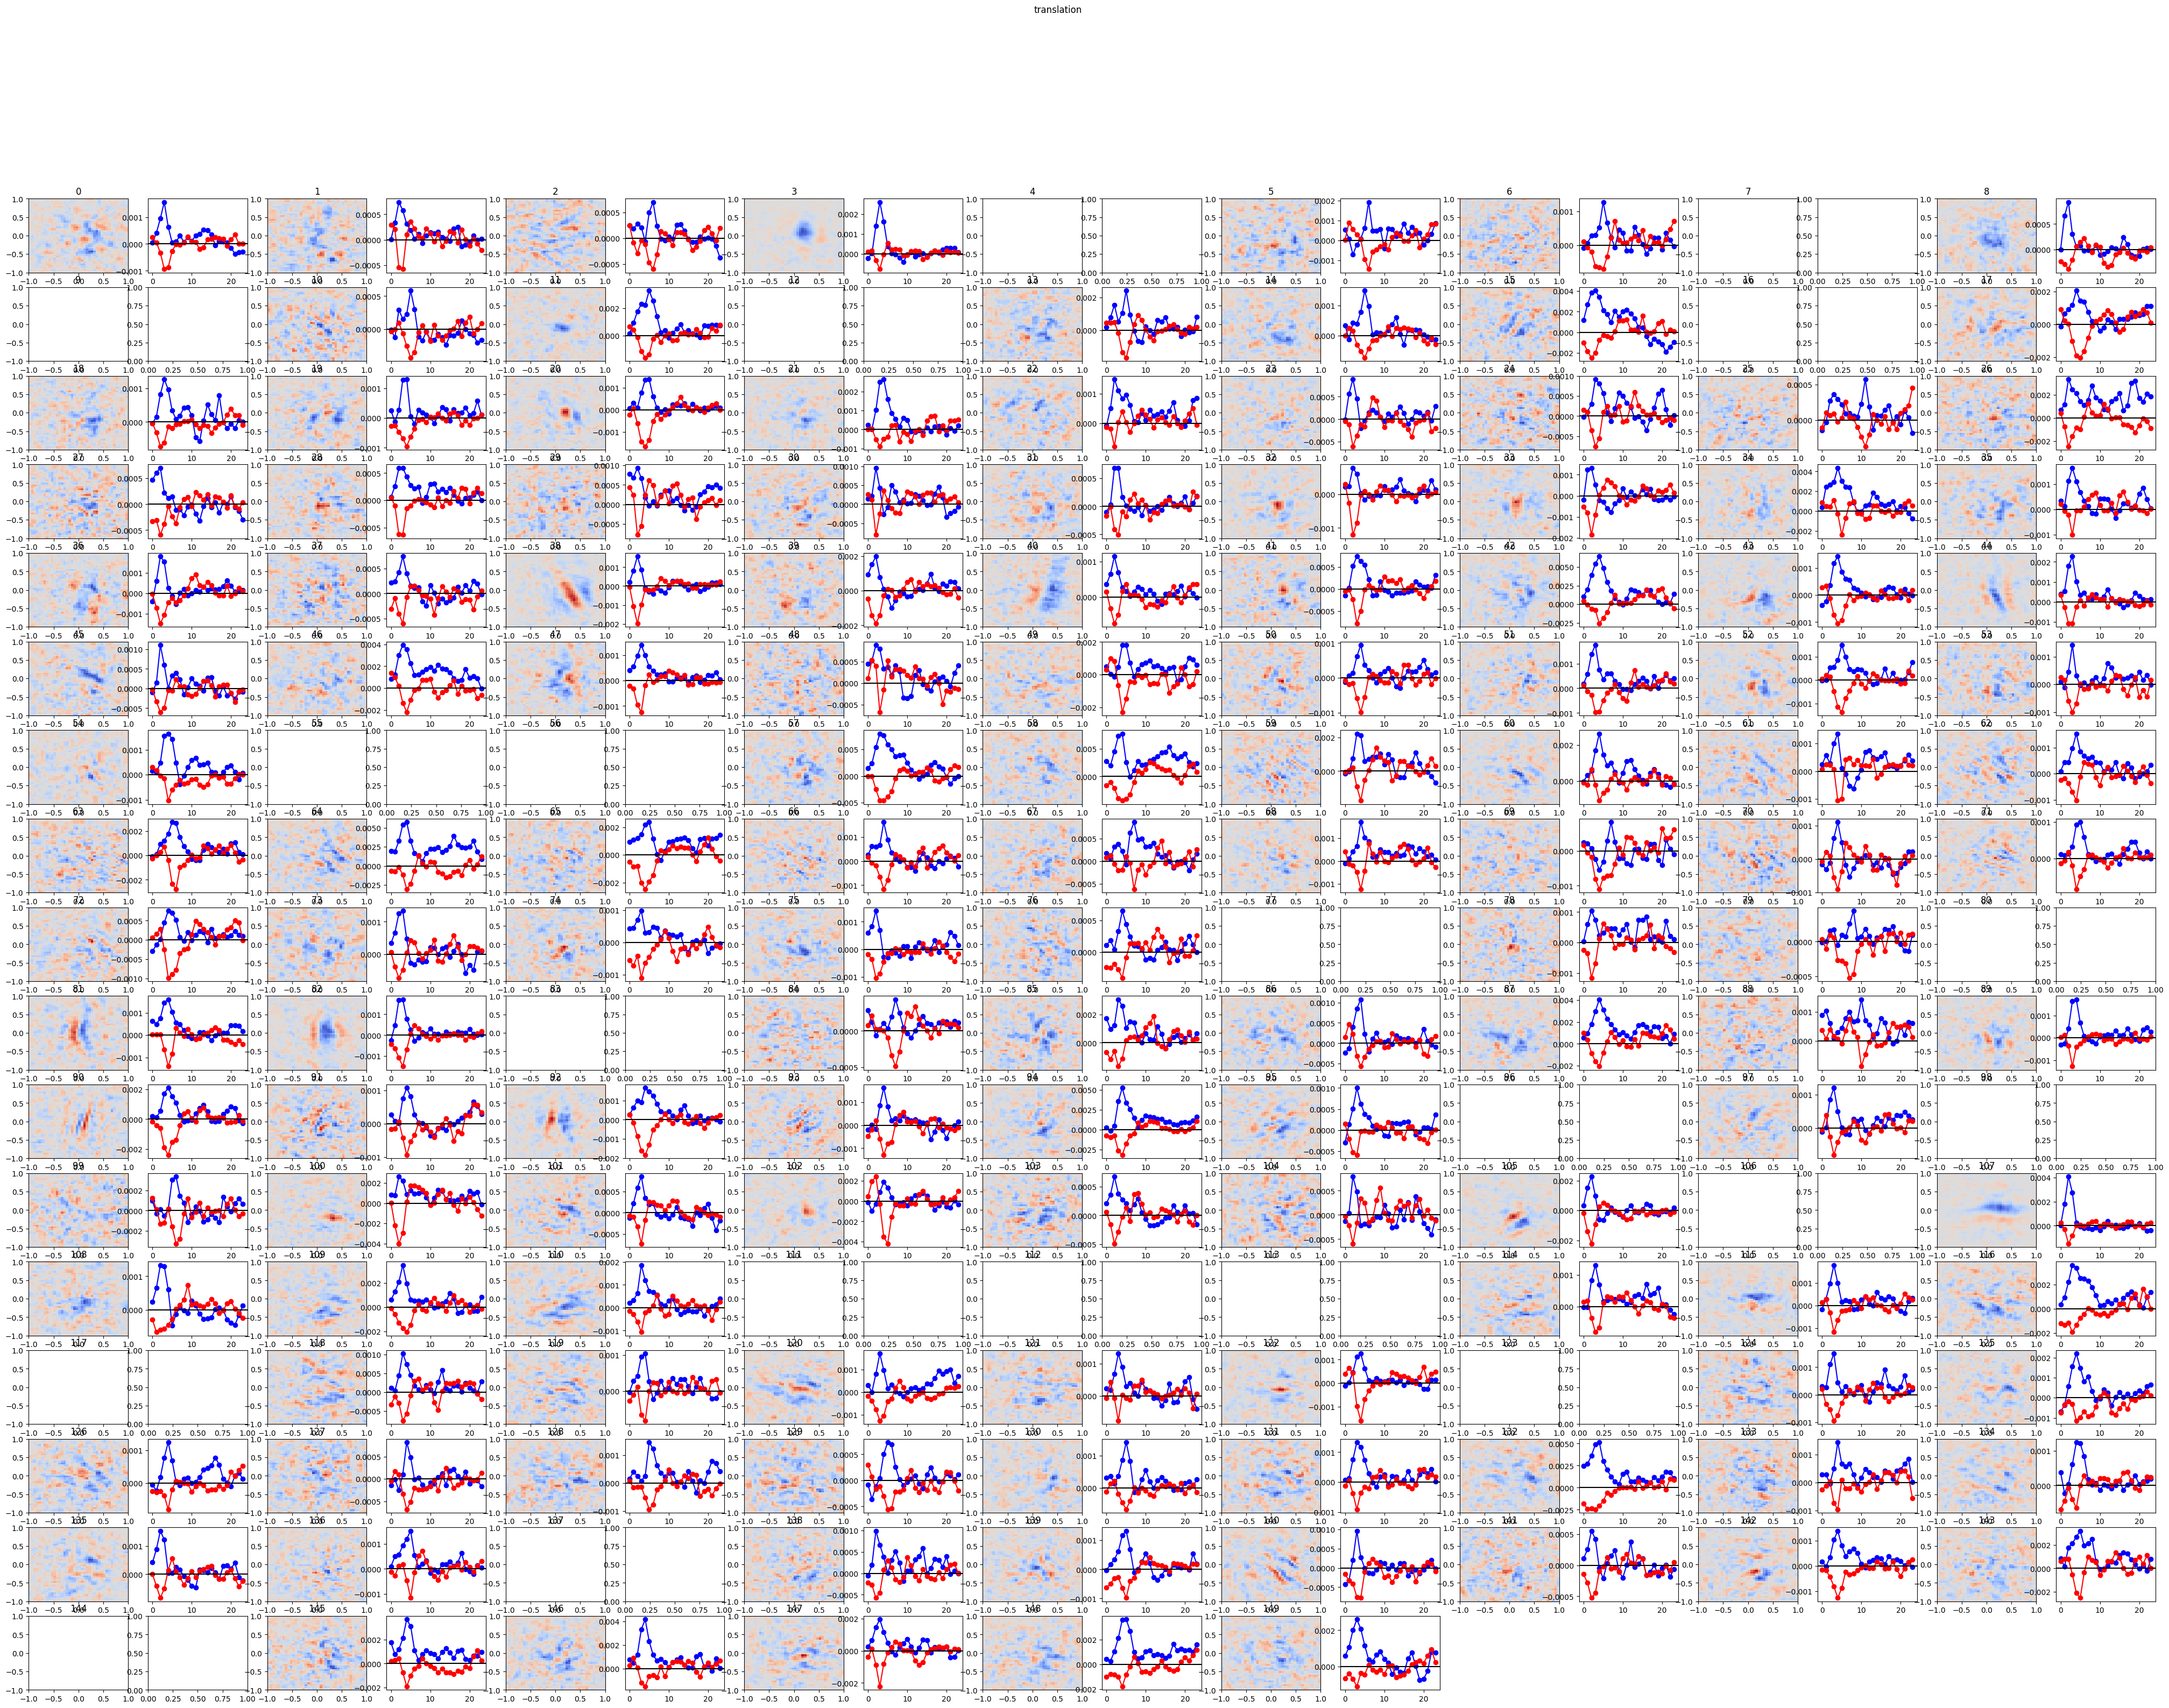

In [16]:
_,_,fig02 =  plot_stas(stas.numpy(), title='no shift')

_,_,fig03 =  plot_stas(stas0.detach().numpy(), title='translation')

## Plot example unit from Figure 4c
unit 20220610_108 is in this dataset and all lags can be plotted below

Note: the crop window is different here than in the main manuscript

The top row below is after shift correction. The bottom row is without shifting.

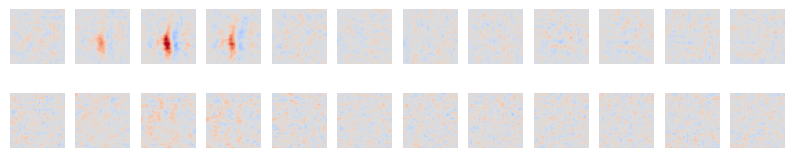

In [17]:
cc = 107 # offset by 1 because python is 0 based indexing

nlags = stas.shape[0]//2 # plot half the lags

# zscore STA for specified neuron
sta = stas0[:,:,:,cc] - stas0[:,:,:,cc].mean() 
sta = sta / sta.std()
sta = sta.detach().numpy()

# no shift
sta1 = stas[:,:,:,cc] - stas0[:,:,:,cc].mean() 
sta1 = sta1 / sta1.std()
sta1 = sta1.detach().numpy()

# plot each lag of the STA for the given neuron
fig = plt.figure(figsize=(10,2))
for ilag in range(nlags):
    plt.subplot(2, nlags, ilag+1)
    plt.imshow(sta[ilag,:,:].T, cmap='coolwarm', vmin=-12, vmax=12)
    plt.axis("off")
    plt.subplot(2, nlags, nlags+ilag+1)
    plt.imshow(sta1[ilag,:,:].T, cmap='coolwarm', vmin=-12, vmax=12)
    plt.axis("off")
    


## Save shifter for use with the Pixel Dataset

In [18]:
overwrite = False

import dill
from copy import deepcopy
shifters = [mod0.shifter]
shifter = deepcopy(shifters[np.argmin([loss0])])

out = {'cids': cids,
    'shifter': shifter,
    'shifters': shifters,
    'vernum': [0],
    'valloss': [loss0],
    'numlags': num_lags,
    'tdownsample': tdownsample,
    'eyerad': valid_eye_rad,
    'input_dims': mod0.input_dims,
    'seed': seed}

fname = 'shifter_' + SESSION_NAME + '_' + ds.spike_sorting + '.p'
fpath = os.path.join(datadir,fname)

if not os.path.exists(fpath) or overwrite:
    print("saving shifter")
    with open(fpath, 'wb') as f:
        dill.dump(out, f)

saving shifter
